# Plotting density maps of ancestral locations for some interesting accessions

## preamble

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import pandas as pd
from sklearn.neighbors import KernelDensity
# import imageio #for gifs

In [3]:
def map_locations_kernel(sample_locations, mle_locations, 
                         additional_points=None, additional_points_colors = ['k'], additional_points_markers = ['o'],
                         grid_size = 0.1, nlevels = 50, cmap = plt.cm.Blues, 
                         figsize = (10,10), title = None, title_size=14, 
                         show = True, fname = None, dpi = 90, 
                         xlims = None, ylims = None, **kwargs):
            
    locs = mle_locations * np.pi / 180. #convert lat long to radians
    locs = locs[np.isnan(locs).any(axis=1) == False] #drop rows with nans

    # Set up the data grid for the contour plot
    xgrid = np.arange(min(sample_locations[:,1]), max(sample_locations[:,1]), grid_size) #long
    ygrid = np.arange(min(sample_locations[:,0]), max(sample_locations[:,0]), grid_size) #lat
    X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
    xy = np.vstack([Y.ravel(), X.ravel()]).T #flip lat and long
    xy *= np.pi / 180. #convert lat long to radians

    # plot map
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
        
    # construct a kernel density estimate of the distribution
    kde = KernelDensity(bandwidth=0.04, metric='haversine',
                        kernel='gaussian', algorithm='ball_tree')
    kde.fit(locs) #fit kernel to data
    Z = np.exp(kde.score_samples(xy)) #inter/extrapolate to grid
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), nlevels)
    ax.contourf(X, Y, Z, levels=levels, cmap=cmap)

    # Set up the map
    if xlims is None:
        llcrnrlon = X.min(); urcrnrlon = X.max() #x range
    else:
        llcrnrlon = xlims[0]; urcrnrlon = xlims[1]
    if ylims is None:
        llcrnrlat = Y.min(); urcrnrlat = Y.max() #y range
    else:
        llcrnrlat = ylims[0]; urcrnrlat = ylims[1] #y range
        
    bm = Basemap(projection='cyl', 
                 llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon, 
                 llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat, 
                 **kwargs)
    bm.drawcoastlines()
    bm.drawcountries()
        
    # plot additional points
    if additional_points is not None:
        
        for i,additional_point in enumerate(additional_points):
            x, y = bm(additional_point[1], additional_point[0])
            ax.scatter(x, y, color=additional_points_colors[i], marker=additional_points_markers[i], zorder=10)        
        
    if title is not None:
        ax.set_title(title, fontsize=title_size)

    if fname is not None:
        plt.savefig(fname, dpi=dpi, bbox_inches = 'tight', pad_inches = 0.1)

    if show:
        plt.show()
    else:
        plt.close()

In [4]:
def filter_samples(locations, group, clusters):

    if group == 'Eurasia':
        not_na = [i for i,j in enumerate(locations) if j[1]>-30] #not in NA (longitude greater than -30), and not missing (since the inequality is false when nan)
    elif group == 'Eurasia-no-Japan':
        not_na = [i for i,j in enumerate(locations) if j[1]>-30 and j[1]<120] #not NA, Japan, or nan
    else:
        print('error: group does not exist!')
        return

    # try to make clusters from pairwise differences  
    #remove = []
    #for cluster in clusters:
    #  remove.append(cluster[1:]) #remove all but first sample in each cluster (a bit of a rough approach)
    #remove = [i for j in remove for i in j] #flatten the list

    # just remove all samples
    remove = np.unique(clusters) #remove all samples that are in a nearly identical pair

    sample_ix = range(len(locations)+1) #index for all samples
    sample_ix_nonidentical = [i for i in sample_ix if i not in remove] #list of nonidentical sample idices
    keep = [i for i in sample_ix_nonidentical if i in not_na] #list of samples to keep

    return keep

In [5]:
def load_data(node,twoNe,u,numiter,threshold,tCutoff,dCutoff,style,tsplits,group,misplaced=False):

    mle_locations = []
    for chromosome in chromosomes:

        fname = datadir + filename + '_chr%d_2Ne%d_u%s_numiter%d_threshold%.1f_tCutoff%d_dCutoff%d_group%s_tsplits%s_node%d_%s.npy' %(chromosome,twoNe,u,numiter,threshold,tCutoff,dCutoff,group,tsplits,node,style)        
        
        try:
            mle_locations.append(np.load(fname))
        except:
            print('missing chromosome %d' %chromosome)
              
    return mle_locations
              
def reorganize_data(mle_locations):

    mle_locations = np.array(mle_locations)
    mle_locations = mle_locations.swapaxes(2,3) #order: chromosome, locus, node, time, dimension
    shape = mle_locations.shape
    mle_locations = mle_locations.reshape(shape[0]*shape[1],shape[2],shape[3],shape[4]) #collapse chromosomes together
    
    return mle_locations

parameters

In [6]:
datadir = '../data/'
filename = '1001G'
chromosomes = range(1,6)
twoNe = 170000
u = 7e-09
numiter = 5
threshold = 0.5
tCutoff = 10000
dCutoff = 1000
ancestor_times = np.logspace(0,3,10) #times we have calculated ancestor locations at - make sure this matches what is in the files
plotdir = '../plots/'
group = 'Eurasia-no-Japan'
tsplits = [10,100,1000]
style = 'ancestor-locations'

load locations of all samples

In [7]:
locations = np.loadtxt(datadir + filename + '.locs')
clusters = np.load(datadir + filename + '_MAF0.05_dCutoff%d_clusters.npy' %dCutoff, allow_pickle=True) #clusters of nearly identical samples
keep = filter_samples(locations, group, clusters)

get info on nodes

In [8]:
# get structure groups
metadata = pd.read_csv(datadir + filename + '_metadata.csv', header=0)
groups = np.array(metadata['admixed group'], dtype='str')
country = np.array(metadata['country'], dtype='str')
site = np.array(metadata['site'], dtype='str')

## japan

let's first look at an extreme example: japan

In [11]:
keep_jpn = filter_samples(locations, 'Eurasia', clusters)
japan_nodes = [i for i,j in enumerate(country) if j=='Japan' and i in keep_jpn]

In [12]:
metadata.loc[japan_nodes]

accession   name CS number country code  latitude  longitude  \
431       7207  Kyoto   CS76535          JPN   35.0085    135.752   
481       7373  Tsu-0   CS77389          JPN   34.4300    136.310   

            collector seq by continent country   admixed group   site  \
431  Hirokazu Tsukaya   Salk      Asia   Japan  Central Europe  Kyoto   
481      Albert Kranz   Mott      Asia   Japan         Admixed    Tsu   

     GTM axis 1  GTM axis 2  t-SNE axis 1  t-SNE axis 2  \
431   -0.610554   -0.007206    -39.019207     12.365108   
481   -0.479694   -0.265504      6.768894    -11.022324   

     Principal component 1  Principal component 2  
431             -15.912223              -1.265591  
481              -9.298506             -14.287948

let's just look at the first, non admixed, sample

In [14]:
node = japan_nodes[0]

mle_locations = load_data(node, twoNe,u,numiter,threshold,tCutoff,dCutoff,style,tsplits,group)
mle_locations = reorganize_data(mle_locations)

1.0


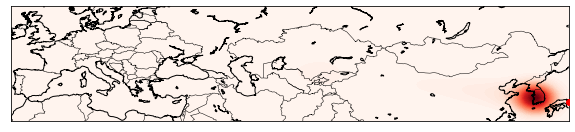

2.154434690031884


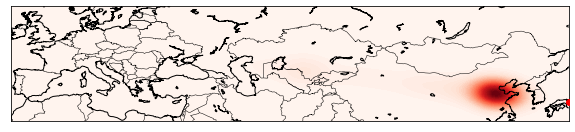

4.641588833612778


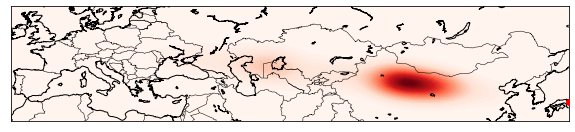

10.0


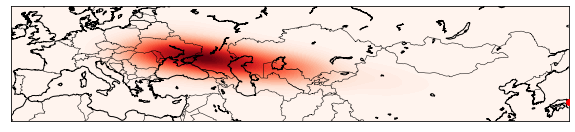

21.544346900318832


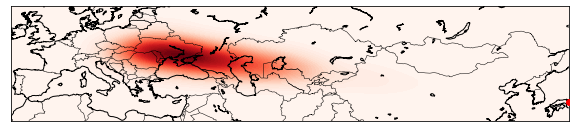

46.41588833612777


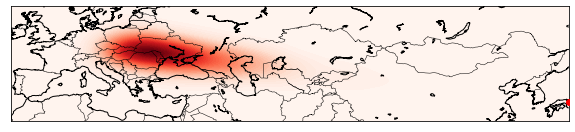

100.0


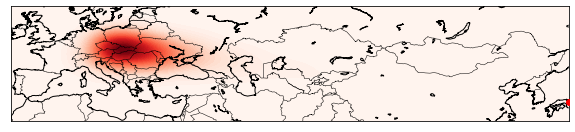

215.44346900318823


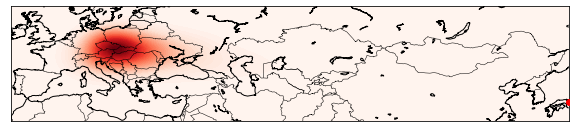

464.15888336127773


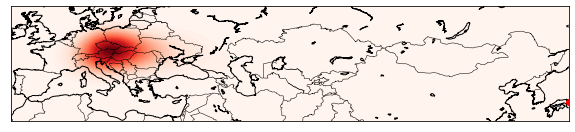

In [17]:
xlims = [-10,locations[node][1]]
ylims = [30,60]
resolution = 'l'
cmap = plt.cm.Reds

for i, t in enumerate(ancestor_times):
    print(t)
    fname = (plotdir + filename + '_ancestor-location-density-map_node%d_time%d_tsplits%s.png' %(node,t,tsplits)).replace(' ','')
#     fname = None
    map_locations_kernel(sample_locations=locations[keep_jpn], 
                         mle_locations=mle_locations[:,0,i], cmap=cmap,
                         additional_points=[locations[node]], additional_points_colors=['red'],
                         fname=fname, xlims=xlims, ylims=ylims, resolution=resolution)

## misplaced relict

and let's see if we can detect a recent migrant from the relict group, which we've misplaced at the mean location

In [9]:
# relict_spain_kept_nodes = [i for i,j in enumerate(groups) if j=='Relict' and country[i]=='Spain' and i in keep and site[i] != 'Can'] #indices of relict samples (not canary islands)
# node = relict_spain_kept_nodes[0]
node = 697

metadata.loc[node]

accession                                9533
name                                 IP-Cem-0
CS number                             CS76763
country code                              ESP
latitude                                41.15
longitude                               -4.32
collector                Carlos Alonso-Blanco
seq by                               Monsanto
continent                              Europe
country                                 Spain
admixed group                          Relict
site                                      NaN
GTM axis 1                          -0.999988
GTM axis 2                          -0.999859
t-SNE axis 1                         -34.1865
t-SNE axis 2                         -39.4301
Principal component 1                -23.8789
Principal component 2               -0.611218
Name: 697, dtype: object

In [14]:
mle_locations = load_data(node,twoNe,u,numiter,threshold,tCutoff,dCutoff,'misplaced-ancestor-locations',tsplits,group)
mle_locations = reorganize_data(mle_locations)

1.0


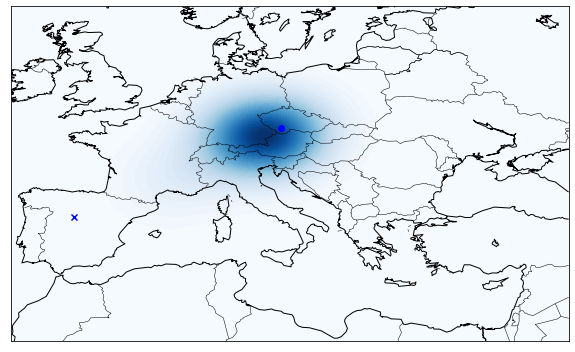

2.154434690031884


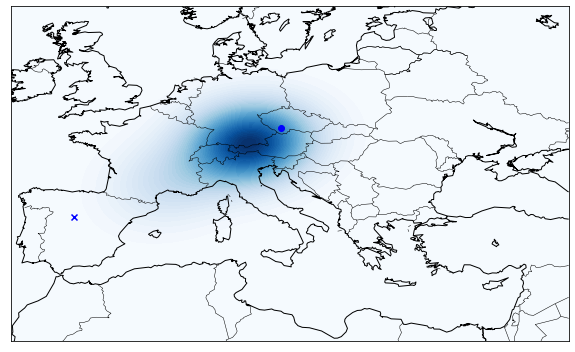

4.641588833612778


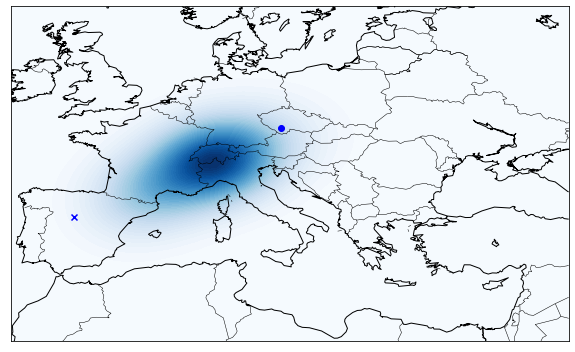

10.0


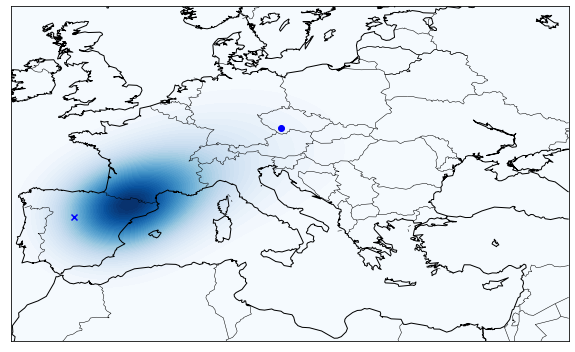

21.544346900318832


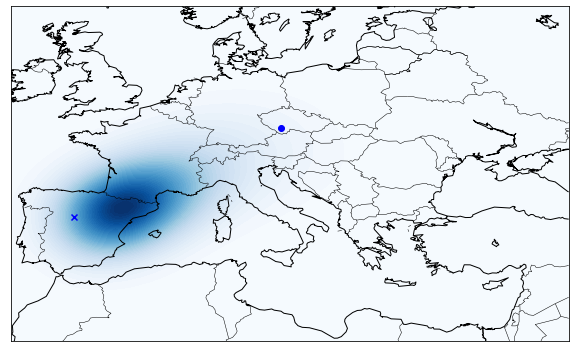

46.41588833612777


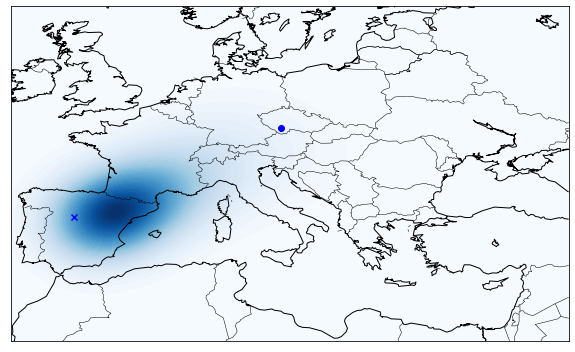

100.0


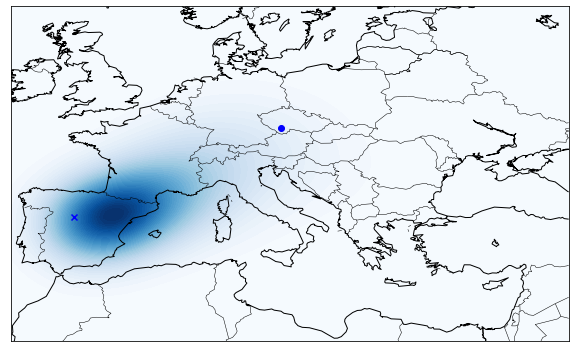

215.44346900318823


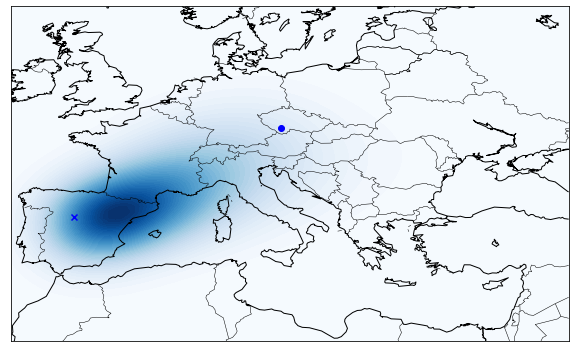

464.15888336127773


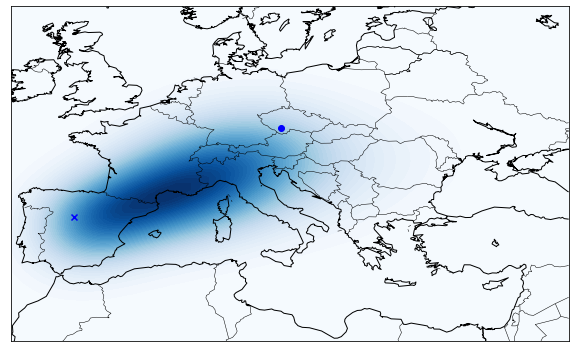

1000.0


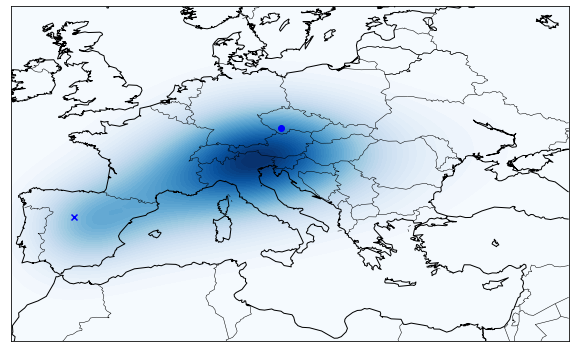

In [18]:
xlims = [-10,40]
ylims = [30,60]
resolution = 'l'
cmap = plt.cm.Blues

for i, t in enumerate(ancestor_times):
    print(t)
    fname = (plotdir + filename + '_misplaced-ancestor-location-density-map_node%d_time%d_tsplits%s.png' %(node,t,tsplits)).replace(' ','')
#     fname = None
    map_locations_kernel(sample_locations=locations[keep], 
                         mle_locations=mle_locations[:,0,i], cmap=cmap,
                         additional_points=[locations[node],np.mean(locations[keep],axis=0)], additional_points_colors=['blue','blue'], additional_points_markers=['x','o'],
                         fname=fname, xlims=xlims, ylims=ylims, resolution=resolution)

## cabo verde

now let's look at another extreme example: cabo verde

In [8]:
cvi_nodes = [i for i,j in enumerate(country) if j=='Cabo Verde' and i in keep]

In [9]:
metadata.loc[cvi_nodes]

accession   name CS number country code  latitude  longitude  \
323       6911  Cvi-0   CS76789          CPV   15.1111   -23.6167   

        collector seq by continent     country admixed group site  GTM axis 1  \
323  Albert Kranz   Salk    Africa  Cabo Verde        Relict  Cvi   -0.965156   

     GTM axis 2  t-SNE axis 1  t-SNE axis 2  Principal component 1  \
323   -0.750907    -28.794218     -43.58334             -20.800105   

     Principal component 2  
323                1.92488

In [10]:
node = cvi_nodes[0]

mle_locations = load_data(node, twoNe,u,numiter,threshold,tCutoff,dCutoff,style,tsplits,group)
mle_locations = reorganize_data(mle_locations)

1.0


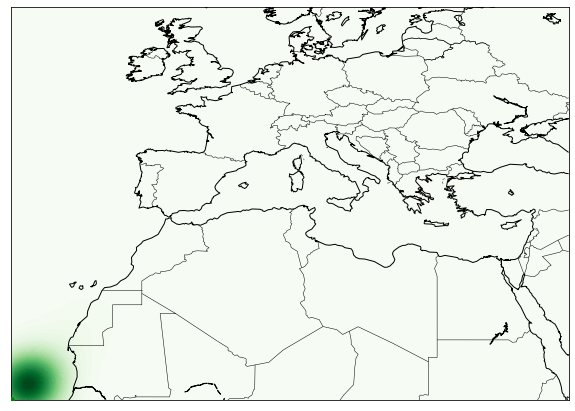

2.154434690031884


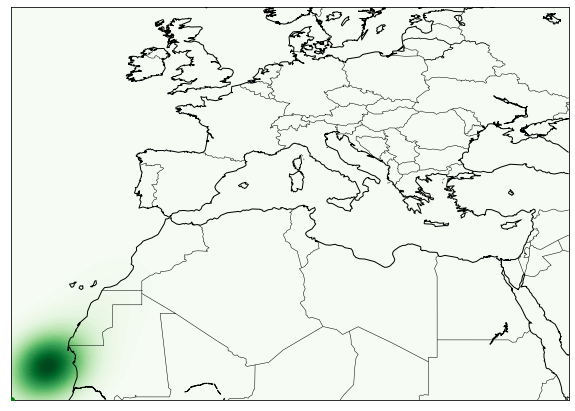

4.641588833612778


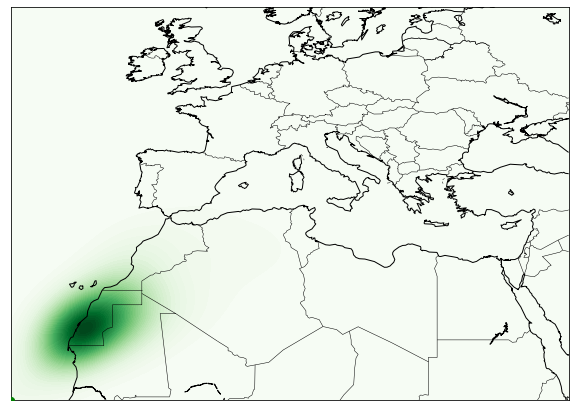

10.0


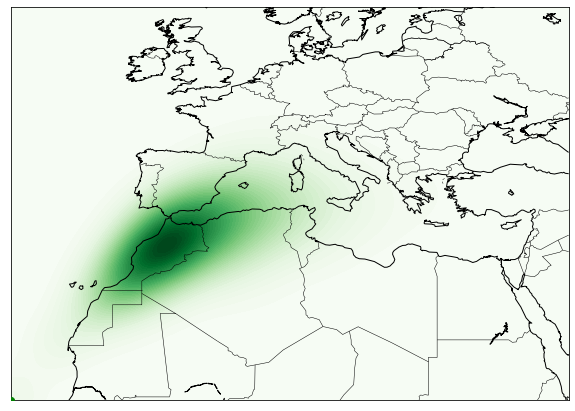

21.544346900318832


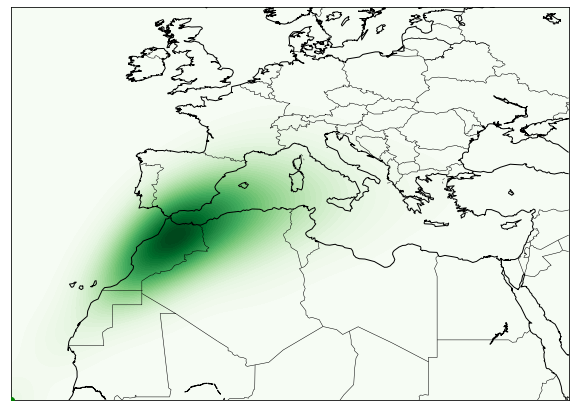

46.41588833612777


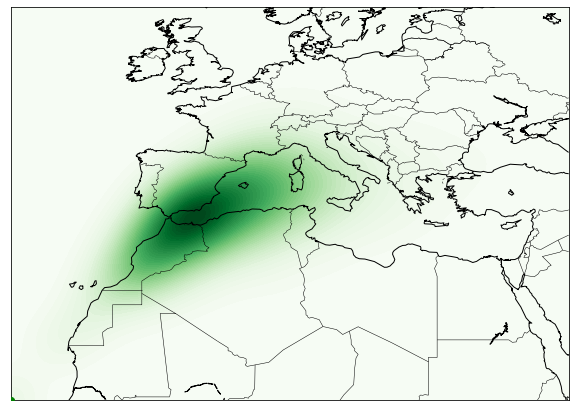

100.0


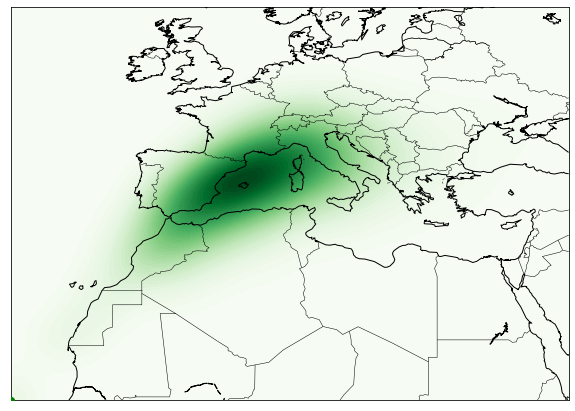

215.44346900318823


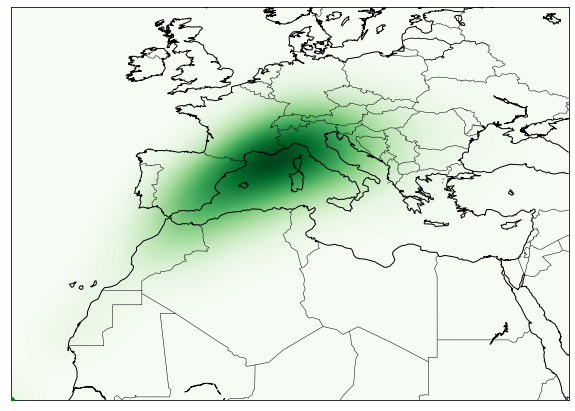

464.15888336127773


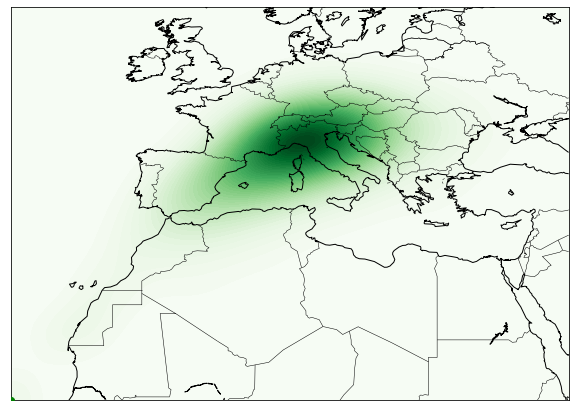

1000.0


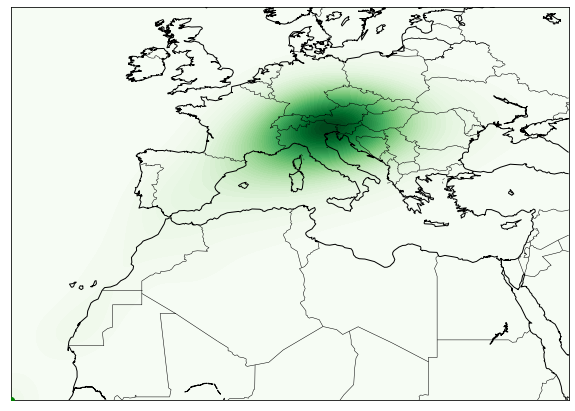

In [12]:
xlims = [locations[node][1],40]
ylims = [locations[node][0],60]
resolution = 'l'
cmap = plt.cm.Greens

for i, t in enumerate(ancestor_times):
    print(t)
    fname = (plotdir + filename + '_ancestor-location-density-map_node%d_time%d_tsplits%s.png' %(node,t,tsplits)).replace(' ','')
#     fname = None
    map_locations_kernel(sample_locations=locations[keep], 
                         mle_locations=mle_locations[:,0,i], cmap=cmap,
                         additional_points=[locations[node]], additional_points_colors=['green'],
                         fname=fname, xlims=xlims, ylims=ylims, resolution=resolution)

compare to a simple histogram, to see all the data

In [38]:
# for i,t in enumerate(ancestor_times):
#     print(t)
#     plt.hist(mle_locations[:,0,i,0]) #latitude
#     plt.show()

why does this go back to europe so fast? arent there trees with only one lineage?

In [20]:
from importlib import reload  
import sparg
sparg = reload(sparg)

In [53]:
focal_node = node
time = 10 #irrelevant number for our purposes here
loci = range(100)

nleaves = []
for chromosome in chromosomes:
    for locus in loci:

        treefile = datadir + '1001G_chr%d_2Ne170000_u7e-09_popsize_numiter5_threshold0.5_processed_trees_locus%d_tCutoff10000.npz' %(chromosome, locus)

        processed_trees = np.load(treefile, allow_pickle=True)

        coal_times = processed_trees['coal_times']
        pcoals = processed_trees['pcoals']
        shared_times = processed_trees['shared_times']
        samples = processed_trees['samples']

        nleaves_i = 0
        for tree,sample in enumerate(samples[0]):
            n,m = sparg._get_focal_index(focal_node, sample) #subtree and sample index of focal_node
            sts = shared_times[0][tree][n] #shared times between all sample lineages in subtree
            atimes = sparg.get_atimes(sts, time, m) #get shared times between sample lineages and ancestor lineage
            if keep is None:
                alltimes = get_alltimes(sts, atimes, keep=keep)
                locs = locations[sample[n]] #locations of samples
            else:
                ixs = np.where(np.in1d(sample[n], keep))[0] #what indices are we keeping location info for
#                 alltimes = sparg.get_alltimes(sts, atimes, keep=ixs) #combine into one covariance matrix (and filter to keep)
#                 sample_keep = [sample[n][ix] for ix in ixs] #keep these samples
#                 locs = locations[sample_keep] #locations of kept samples
    
            nleaves_i += len(ixs)
    
        nleaves.append(nleaves_i/len(samples[0]))
    

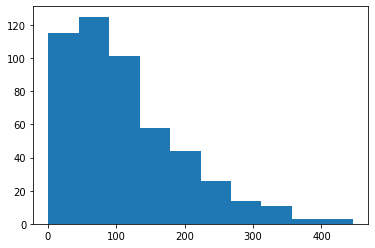

In [54]:
plt.hist(nleaves)
plt.show()

In [55]:
np.mean(nleaves)

113.0086

percent of trees with only one leaf (the cabo verde sample itself)

In [59]:
len([i for i in nleaves if i < 2])/len(nleaves)

0.016

not inconsistent with https://1001genomes.github.io/admixture-map/?

now let's check the method is working by looking at a tree where there is only one sample and making sure the mle is the location of that sample

In [58]:
[i for i,j in enumerate(nleaves) if j < 2]

[53, 220, 223, 263, 284, 286, 358, 369]

In [60]:
chromosome = 1
locus = 53

treefile = datadir + '1001G_chr%d_2Ne170000_u7e-09_popsize_numiter5_threshold0.5_processed_trees_locus%d_tCutoff10000.npz' %(chromosome, locus)

processed_trees = np.load(treefile, allow_pickle=True)

coal_times = processed_trees['coal_times']
pcoals = processed_trees['pcoals']
shared_times = processed_trees['shared_times']
samples = processed_trees['samples']

nleaves_i = 0
for tree,sample in enumerate(samples[0]):
    n,m = sparg._get_focal_index(focal_node, sample) #subtree and sample index of focal_node
    sts = shared_times[0][tree][n] #shared times between all sample lineages in subtree
    atimes = sparg.get_atimes(sts, time, m) #get shared times between sample lineages and ancestor lineage
    if keep is None:
        alltimes = get_alltimes(sts, atimes, keep=keep)
        locs = locations[sample[n]] #locations of samples
    else:
        ixs = np.where(np.in1d(sample[n], keep))[0] #what indices are we keeping location info for
        alltimes = sparg.get_alltimes(sts, atimes, keep=ixs) #combine into one covariance matrix (and filter to keep)
        sample_keep = [sample[n][ix] for ix in ixs] #keep these samples
        locs = locations[sample_keep] #locations of kept samples
    

In [64]:
metadata.iloc[sample_keep]

accession   name CS number country code  latitude  longitude  \
323       6911  Cvi-0   CS76789          CPV   15.1111   -23.6167   

        collector seq by continent     country admixed group site  GTM axis 1  \
323  Albert Kranz   Salk    Africa  Cabo Verde        Relict  Cvi   -0.965156   

     GTM axis 2  t-SNE axis 1  t-SNE axis 2  Principal component 1  \
323   -0.750907    -28.794218     -43.58334             -20.800105   

     Principal component 2  
323                1.92488

In [67]:
mle_locations[53]

array([[[ 15.1111, -23.6167],
        [ 15.1111, -23.6167],
        [ 15.1111, -23.6167],
        [ 15.1111, -23.6167],
        [ 15.1111, -23.6167],
        [ 15.1111, -23.6167],
        [ 15.1111, -23.6167],
        [ 15.1111, -23.6167],
        [ 15.1111, -23.6167],
        [ 15.1111, -23.6167]]])

good!

same thing with canary islands?

In [49]:
focal_node = 387
time = 10 #irrelevant number for our purposes here
loci = range(100)

nleaves = []
for chromosome in chromosomes:
    for locus in loci:

        treefile = datadir + '1001G_chr%d_2Ne170000_u7e-09_popsize_numiter5_threshold0.5_processed_trees_locus%d_tCutoff10000.npz' %(chromosome, locus)

        processed_trees = np.load(treefile, allow_pickle=True)

        coal_times = processed_trees['coal_times']
        pcoals = processed_trees['pcoals']
        shared_times = processed_trees['shared_times']
        samples = processed_trees['samples']

        nleaves_i = 0
        for tree,sample in enumerate(samples[0]):
            n,m = sparg._get_focal_index(focal_node, sample) #subtree and sample index of focal_node
            sts = shared_times[0][tree][n] #shared times between all sample lineages in subtree
            atimes = sparg.get_atimes(sts, time, m) #get shared times between sample lineages and ancestor lineage
            if keep is None:
                alltimes = get_alltimes(sts, atimes, keep=keep)
                locs = locations[sample[n]] #locations of samples
            else:
                ixs = np.where(np.in1d(sample[n], keep))[0] #what indices are we keeping location info for
#                 alltimes = sparg.get_alltimes(sts, atimes, keep=ixs) #combine into one covariance matrix (and filter to keep)
#                 sample_keep = [sample[n][ix] for ix in ixs] #keep these samples
#                 locs = locations[sample_keep] #locations of kept samples
    
            nleaves_i += len(ixs)
    
        nleaves.append(nleaves_i/len(samples[0]))
    

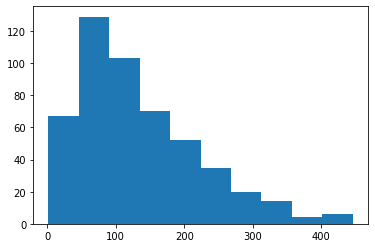

In [50]:
plt.hist(nleaves)
plt.show()

In [51]:
np.mean(nleaves)

131.89020000000002

In [52]:
len([i for i in nleaves if i < 2])/len(nleaves)

0.0

so looks like the canary islands is even less of an outgroup

## non-relict, admixed, relict

three nodes from mainland spain with different histories

In [8]:
# relict_spain_kept_nodes = [i for i,j in enumerate(groups) if j=='Relict' and country[i]=='Spain' and i in keep and site[i] != 'Can'] #indices of relict samples
# admixed_spain_kept_nodes = [i for i,j in enumerate(groups) if j=='Admixed' and country[i]=='Spain' and i in keep and site[i] != 'Can'] #indices of admixed samples
# nonrelict_spain_kept_nodes = [i for i,j in enumerate(groups) if j=='Spain' and country[i]=='Spain' and i in keep and site[i] != 'Can'] #indices of spain samples
# nodes = [relict_spain_kept_nodes[0], admixed_spain_kept_nodes[0], nonrelict_spain_kept_nodes[0]] #one of each (just take the first)

nodes = [338,694,697]
metadata.loc[nodes]

accession      name CS number country code  latitude  longitude  \
338       6933      LL-0   CS77047          ESP     41.59       2.49   
694       9530  IP-Car-1   CS76742          ESP     38.25      -4.32   
697       9533  IP-Cem-0   CS76763          ESP     41.15      -4.32   

                collector    seq by continent country admixed group site  \
338          Albert Kranz      Salk    Europe   Spain         Spain   Ll   
694  Carlos Alonso-Blanco  Monsanto    Europe   Spain       Admixed  NaN   
697  Carlos Alonso-Blanco  Monsanto    Europe   Spain        Relict  NaN   

     GTM axis 1  GTM axis 2  t-SNE axis 1  t-SNE axis 2  \
338   -0.165439   -0.948277    -24.749653    -52.014904   
694   -0.749992   -0.994689     -4.677506    -44.512318   
697   -0.999988   -0.999859    -34.186466    -39.430054   

     Principal component 1  Principal component 2  
338              -9.610200             -27.017690  
694             -14.016522             -19.213922  
697             -23.878864              -0.611218

checked https://1001genomes.github.io/admixture-map/ to make sure relict is 100% relict and non-relict/spain is 100% spain and admixed is near 50:50 relict and spain.

338 1.0


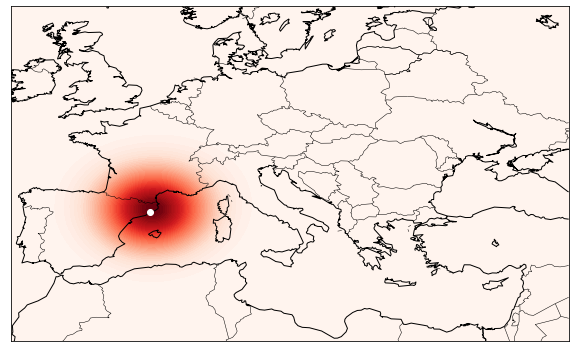

338 2.154434690031884


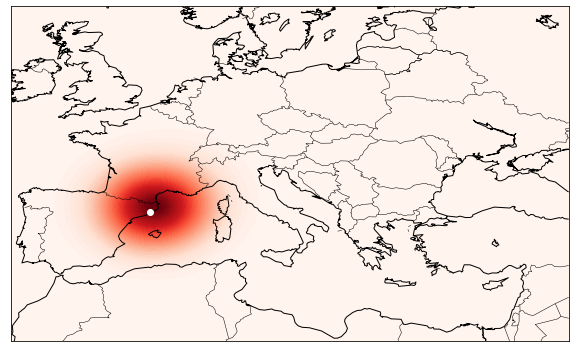

338 4.641588833612778


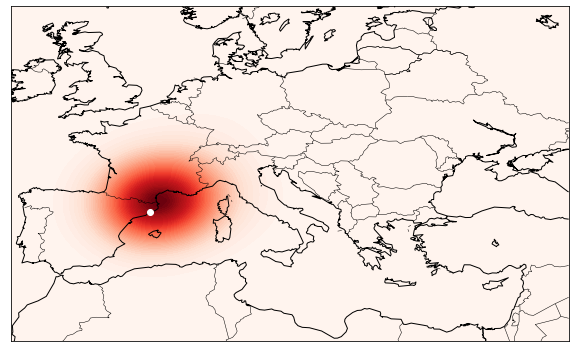

338 10.0


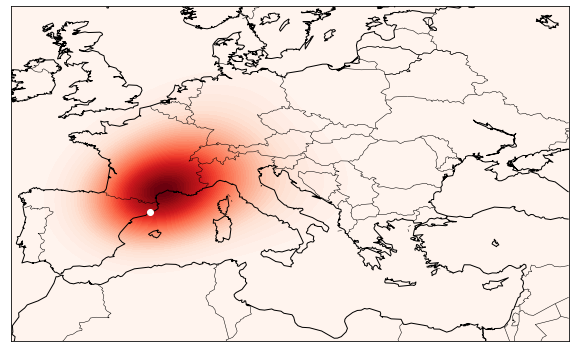

338 21.544346900318832


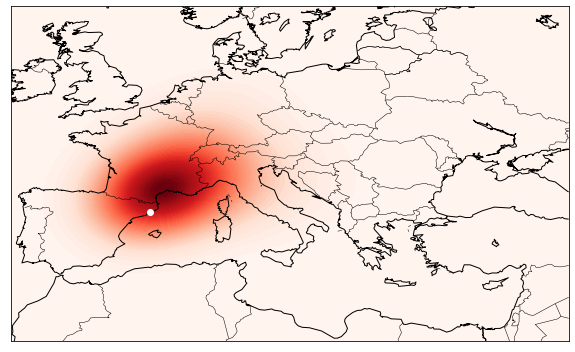

338 46.41588833612777


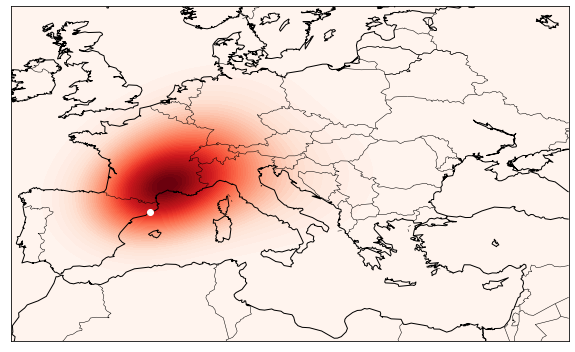

338 100.0


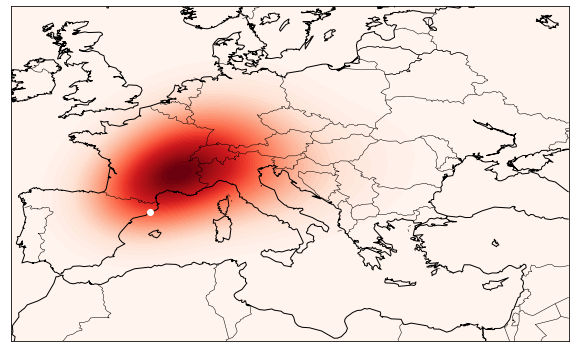

338 215.44346900318823


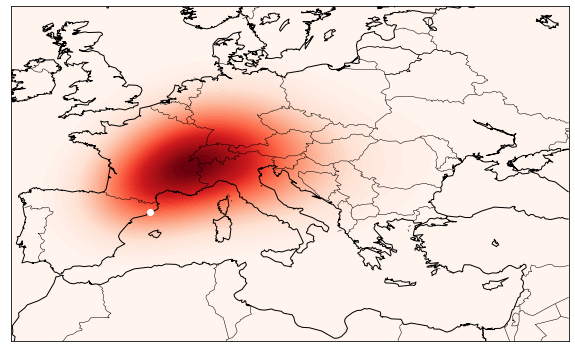

338 464.15888336127773


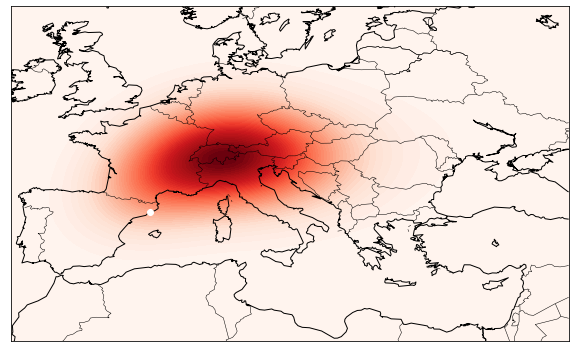

338 1000.0


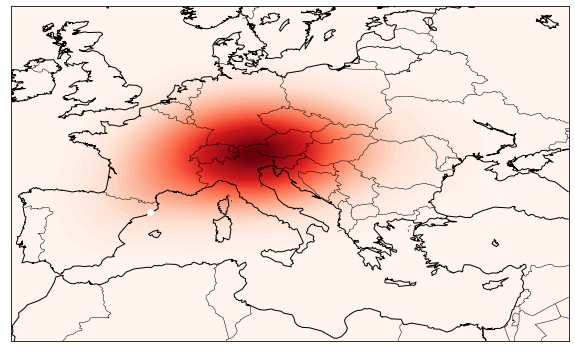

694 1.0


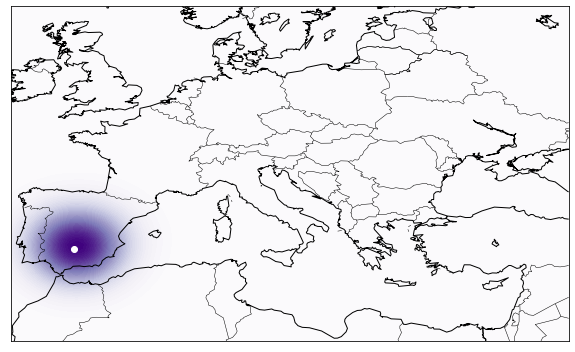

694 2.154434690031884


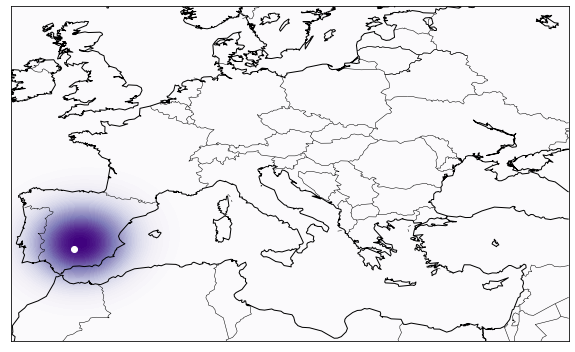

694 4.641588833612778


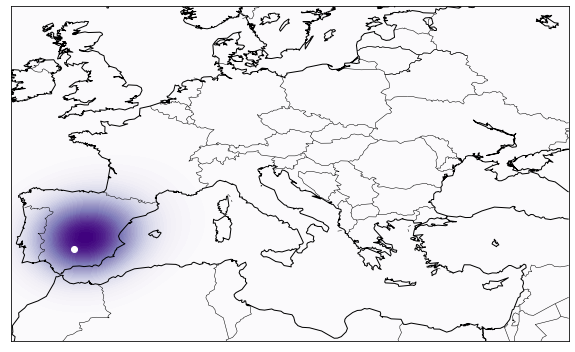

694 10.0


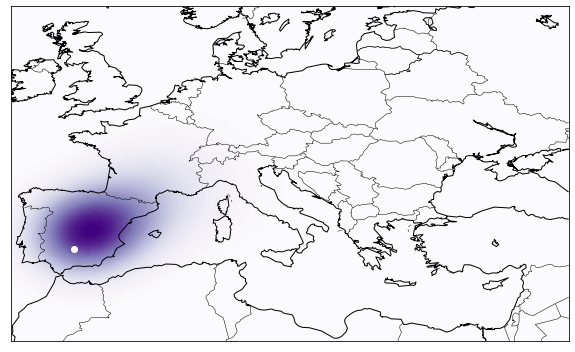

694 21.544346900318832


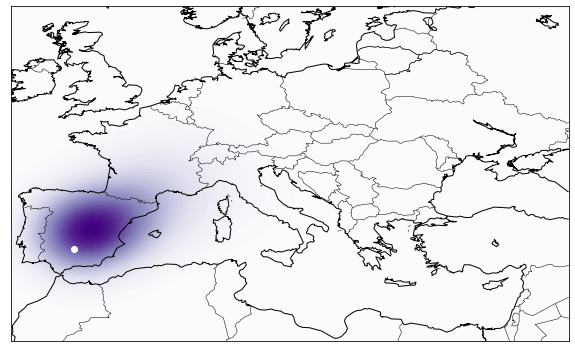

694 46.41588833612777


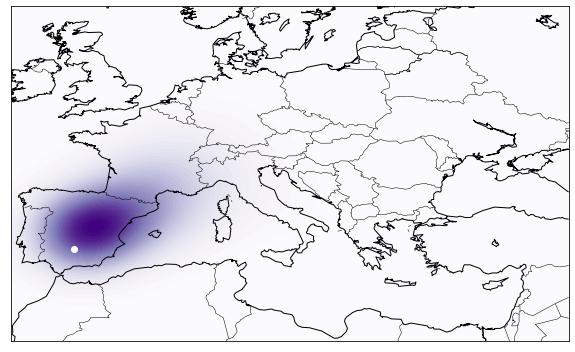

694 100.0


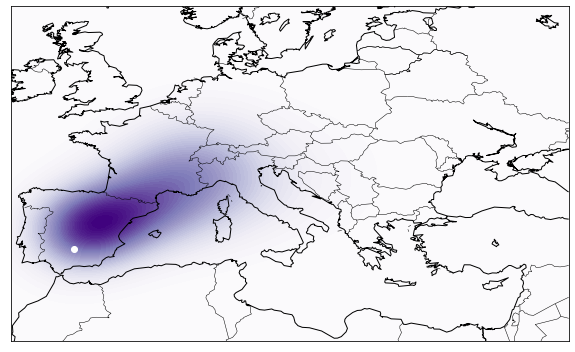

694 215.44346900318823


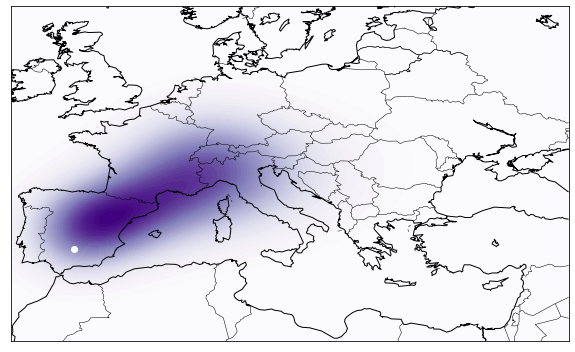

694 464.15888336127773


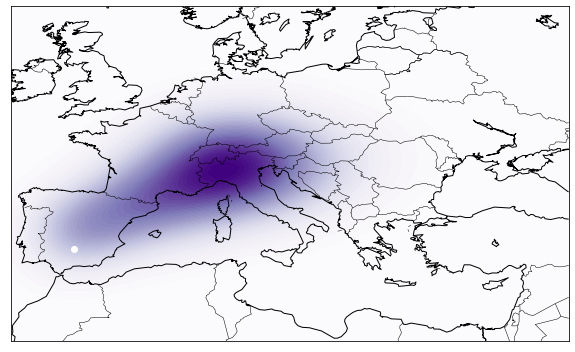

694 1000.0


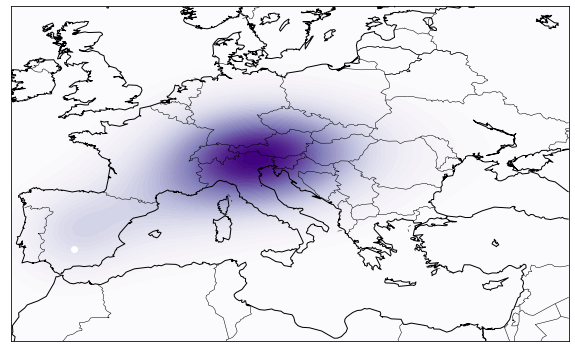

697 1.0


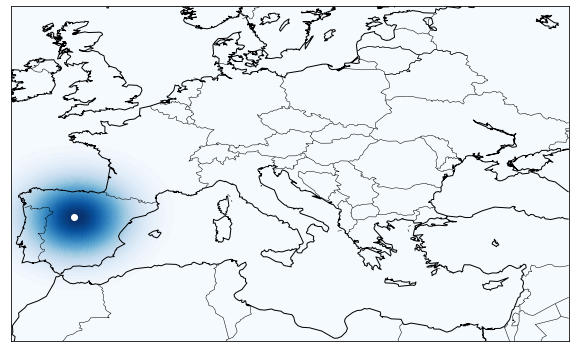

697 2.154434690031884


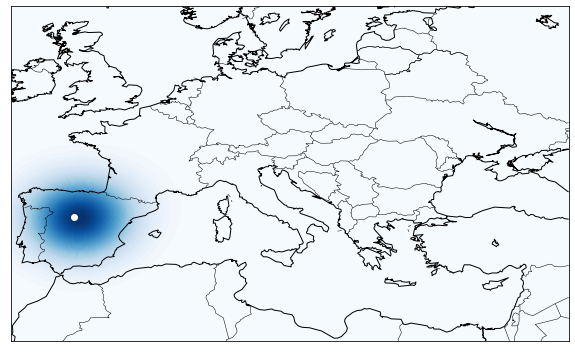

697 4.641588833612778


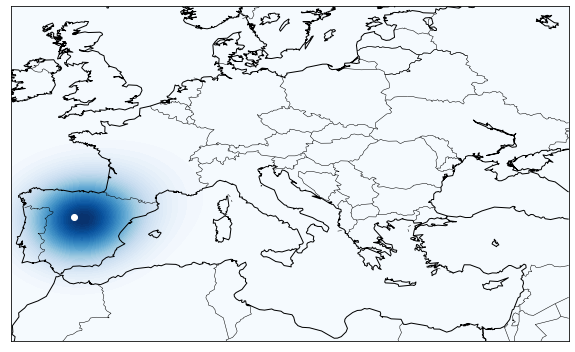

697 10.0


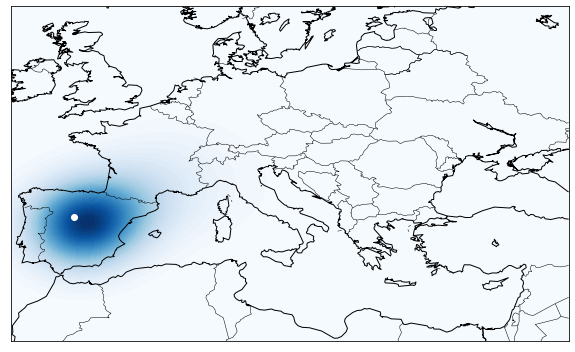

697 21.544346900318832


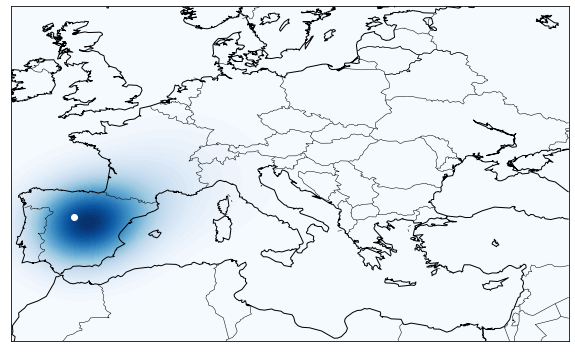

697 46.41588833612777


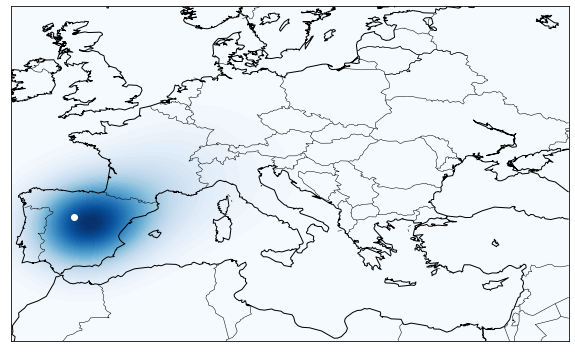

697 100.0


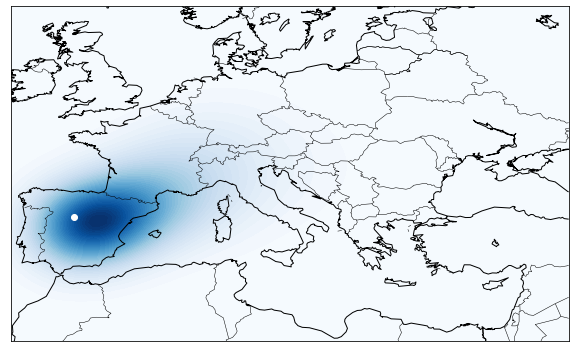

697 215.44346900318823


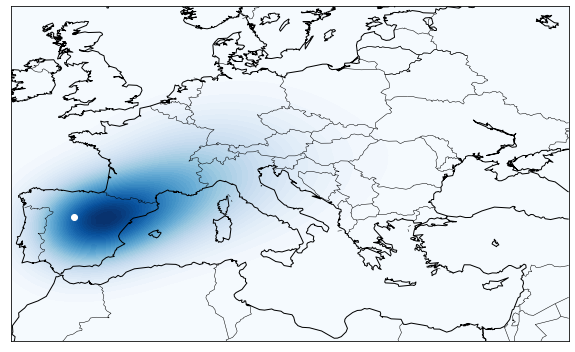

697 464.15888336127773


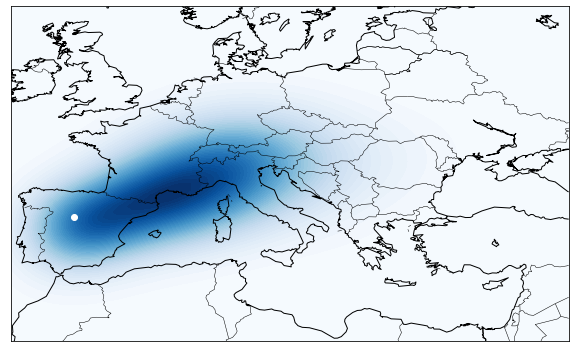

697 1000.0


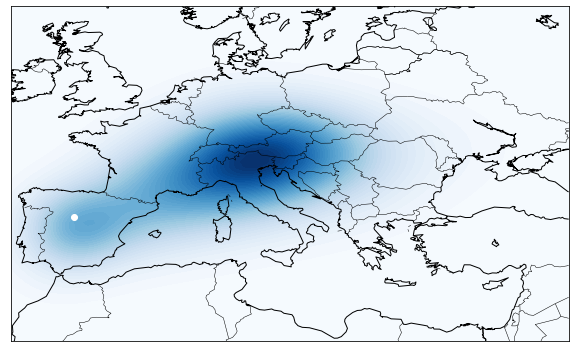

In [12]:
xlims = [-10,40]
ylims = [30,60]
resolution = 'l'
cmaps = [plt.cm.Reds, plt.cm.Purples, plt.cm.Blues]
# point_colors = ['red','purple','blue']
point_colors = ['white','white','white']

for j,node in enumerate(nodes):

    mle_locations = load_data(node,twoNe,u,numiter,threshold,tCutoff,dCutoff,style,tsplits,group)
    mle_locations = reorganize_data(mle_locations)

    for i, t in enumerate(ancestor_times):
        print(node,t)
        fname = (plotdir + filename + '_ancestor-location-density-map_node%d_time%d_tsplits%s.png' %(node,t,tsplits)).replace(' ','')
    #     fname = None
        map_locations_kernel(sample_locations=locations[keep], 
                             mle_locations=mle_locations[:,0,i], cmap=cmaps[j],
                             additional_points=[locations[node]], additional_points_colors=[point_colors[j]],
                             fname=fname, xlims=xlims, ylims=ylims, resolution=resolution)